In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import fastreg.linear as frl
import fastreg.general as frg
import fastreg.testing as frt
%matplotlib inline

### Generate Data

In [13]:
data = frt.dataset(N=1_000_000, K1=10, K2=100, seed=89320432)
data.head()

,id1,id2,x1,x2,yhat0,yhat,y0,y,Eb0,Eb,...,Ep0,Ep,p0,p,pz0,pz,nb0,nb,nbz0,nbz
0,4,99,-0.232286,-1.106499,-0.633585,0.756415,1.997507,0.034401,0.346698,0.680575,...,0.530686,2.130624,0,3,0,3,0,1,0,1
1,8,98,0.457063,0.585081,0.588167,2.368167,2.215314,2.489864,0.642945,0.914367,...,1.800685,10.677805,1,11,1,11,2,26,2,0
2,8,73,0.761536,-0.705039,-0.094563,1.435437,0.518160,3.194336,0.476377,0.807747,...,0.909771,4.201481,3,4,3,0,0,5,0,5
3,8,40,-0.251006,-0.884939,-0.506265,0.693735,-1.399765,0.015946,0.376069,0.666797,...,0.602743,2.001176,0,4,0,4,0,0,0,0
4,6,90,-1.211539,1.763510,0.794644,2.294644,2.340393,2.163917,0.688828,0.908432,...,2.213653,9.920903,8,10,8,10,0,18,0,18


### Normal OLS

In [14]:
%time smf.ols('y0 ~ x1 + x2', data=data).fit().params

CPU times: user 483 ms, sys: 300 ms, total: 783 ms
Wall time: 148 ms


Intercept    0.099722
x1           0.299900
x2           0.600421
dtype: float64

In [15]:
%time frl.ols(y='y0', x=['x1', 'x2'], data=data)

CPU times: user 53.3 ms, sys: 21.3 ms, total: 74.6 ms
Wall time: 23.6 ms


,coeff,stderr,low95,high95,pvalue
one,0.099722,0.001000,0.097763,0.101681,0.0
x1,0.299900,0.000999,0.297941,0.301858,0.0
x2,0.600421,0.000998,0.598465,0.602378,0.0


### Sparse OLS

In [16]:
%time frl.ols(y='y', x=['x1', 'x2'], fe=['id1', 'id2'], data=data)

CPU times: user 627 ms, sys: 4.49 ms, total: 631 ms
Wall time: 609 ms


,coeff,stderr,low95,high95,pvalue
one,0.101112,0.010405,0.080717,0.121506,0.0
x1,0.300678,0.001000,0.298719,0.302637,0.0
x2,0.598699,0.000998,0.596742,0.600656,0.0
id1=1,0.095159,0.004473,0.086391,0.103927,0.0
id1=2,0.194404,0.004468,0.185646,0.203161,0.0
...,...,...,...,...,...
id2=95,0.952153,0.014124,0.924471,0.979836,0.0
id2=96,0.962016,0.014154,0.934275,0.989757,0.0
id2=97,0.990319,0.014160,0.962565,1.018072,0.0
id2=98,0.984403,0.014149,0.956672,1.012135,0.0


In [17]:
%time frl.ols(y='y', x=['x1', 'x2'], absorb=('id1', 'id2'), data=data)

CPU times: user 846 ms, sys: 379 ms, total: 1.22 s
Wall time: 455 ms


,coeff,stderr,low95,high95,pvalue
one,1.045036,0.000925,1.043223,1.046849,0.0
x1,0.300678,0.000990,0.298739,0.302618,0.0
x2,0.598699,0.000971,0.596796,0.600601,0.0


### Poisson

In [20]:
%time beta, sigma = frg.poisson(y='p0', x=['x1', 'x2'], data=data, epochs=5)

[  0] -0.8280: 0.2405
[  1] -0.6624: 0.3180
[  2] -0.6223: 0.3346
[  3] -0.6205: 0.3346
[  4] -0.6205: 0.3346
CPU times: user 6.71 s, sys: 1.18 s, total: 7.88 s
Wall time: 5.51 s


In [21]:
%time beta, sigma = frg.poisson(y='p', x=['x1', 'x2'], fe=['id1', 'id2'], data=data, epochs=5)

[  0] 0.8351: 0.2442
[  1] 2.3344: 0.3485
[  2] 2.5404: 0.3738
[  3] 2.5505: 0.3689
[  4] 2.5505: 0.3657
CPU times: user 12.9 s, sys: 2.27 s, total: 15.2 s
Wall time: 10.6 s


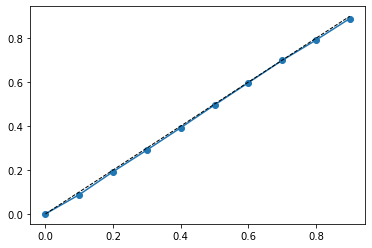

In [22]:
bid1 = np.arange(10)/10
plt.plot(bid1, beta['id1']-beta['id1'][0], marker='o')
plt.plot(bid1, bid1, linestyle='--', linewidth=1, color='k');

### Ultra Wide

In [42]:
N = 2_000_000
df = pd.DataFrame({ 
    'x1': np.random.rand(N), 
    'x2': np.random.rand(N), 
    'id1': np.ceil(np.arange(N)/200+1e-7).astype(np.int),
    'id2': np.random.randint(1, 10001, size=N)
})
df['y'] = df['x1'] + 2*df['x2'] + np.log10(df['id1']) + np.log10(df['id2']) + np.random.randn(N)

In [43]:
%time frl.ols(y='y', x=['x1', 'x2'], absorb=['id1', 'id2'], data=df)

CPU times: user 2.48 s, sys: 1.19 s, total: 3.67 s
Wall time: 2.87 s


,coeff,stderr,low95,high95,pvalue
one,7.130328,0.001871,7.126661,7.133995,0.0
x1,1.000800,0.002451,0.995996,1.005603,0.0
x2,2.000324,0.002451,1.995521,2.005127,0.0


In [44]:
%time beta, sigma = frg.ordinary_least_squares(y='y', x=['x1', 'x2'], fe=['id1', 'id2'], data=df, epochs=10, stderr=False)

[  0] -18.8119: 0.4889
[  1] -4.5593: 0.9647
[  2] -1.8222: 1.4436
[  3] -1.1681: 1.9268
[  4] -0.6874: 1.9705
[  5] -0.6495: 1.8507
[  6] -0.6485: 1.8133
[  7] -0.6407: 1.8083
[  8] -0.6338: 1.8086
[  9] -0.6278: 1.8099
CPU times: user 53.5 s, sys: 10 s, total: 1min 3s
Wall time: 44.7 s
